# Loading the libs

In [1]:
import nltk
from nltk.corpus import stopwords
import os
import numpy as np
import string
import pandas as pd
import math
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from copy import deepcopy

import sklearn
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

/home/simon/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Downloading nltk corpus

In [191]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /home/simon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/simon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/simon/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [5]:
stopword = set(stopwords.words('english'))
punctuat = set(string.punctuation)

## Listing all files

In [4]:
pos_files = []
for root, dirs, files in os.walk("review_polarity/txt_sentoken/pos"):  
    for filename in files:
        if '.txt' in filename:
            pos_files.append(os.path.join(root, filename))
neg_files = []
for root, dirs, files in os.walk("review_polarity/txt_sentoken/neg"):  
    for filename in files:
        if '.txt' in filename:
            neg_files.append(os.path.join(root, filename))

## Reading the files

In [5]:
data = pd.DataFrame(columns=['text', 'type'])
for filename in pos_files:
    with open(filename, encoding='utf-8') as f:
        data= data.append({'text' : f.read().lower().translate(str.maketrans('','',string.punctuation)), 'type' : 'pos'}, ignore_index=True)
for filename in neg_files:
    with open(filename, encoding='utf-8') as f:
        data= data.append({'text' : f.read().lower().translate(str.maketrans('','',string.punctuation)), 'type' : 'neg'}, ignore_index=True)
data = data.sample(frac=1)

In [8]:
def visualize(label):
  words = ''
  for msg in data[data['type'] == label]['text']:
    msg = msg.lower()
    words += msg + ' '
  wordcloud = WordCloud(width=600, height=400).generate(words)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

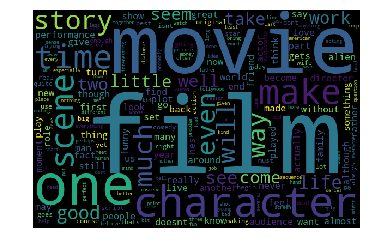

In [18]:
visualize('pos')

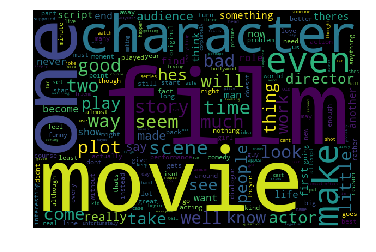

In [19]:
visualize('neg')

In [6]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['text'])
y = data['type'].as_matrix()

In [7]:
def get_score(index, score, matrix, order):
    X_ = matrix[index]
    indexes = (X_ >= score).nonzero()
    indexes[1].tolist()
    scores = []
    for value in indexes[1]:
        scores.append((vectorizer.get_feature_names()[value], matrix[index, value]))
    scores = sorted(scores, key=lambda tup: tup[1])
    if order == 'ascending':
        return scores
    elif order == 'descending':
        return scores[::-1]

In [8]:
get_score(0, 0.1, X, 'descending')

[('the', 0.31021338417794125),
 ('shakespeare', 0.2686600236431433),
 ('henslowe', 0.18861916460237796),
 ('is', 0.1848202887033885),
 ('that', 0.17123997340818695),
 ('in', 0.1681024328176523),
 ('to', 0.14267300435062155),
 ('of', 0.1426017212558233),
 ('queen', 0.14060504867477258),
 ('and', 0.1258250481669029),
 ('quality', 0.11737087554831306),
 ('elizabeth', 0.11595559504648101),
 ('love', 0.10736019646280884),
 ('judi', 0.10556763007013802),
 ('dench', 0.10556763007013802),
 ('it', 0.1039322167337357),
 ('be', 0.10343489074097505)]

In [55]:
threshold = np.linspace(start = 0.0, stop = 1.0, num = 25)
threshold

array([0.        , 0.04166667, 0.08333333, 0.125     , 0.16666667,
       0.20833333, 0.25      , 0.29166667, 0.33333333, 0.375     ,
       0.41666667, 0.45833333, 0.5       , 0.54166667, 0.58333333,
       0.625     , 0.66666667, 0.70833333, 0.75      , 0.79166667,
       0.83333333, 0.875     , 0.91666667, 0.95833333, 1.        ])

In [56]:
def find_threshold(model, thresholds, X, y):
    test_accuracy = []
    train_accuracy = []
    for thresh in thresholds:
        X__ = deepcopy(X)
        X__[X__ < thresh] = 0
        X_train, X_test, y_train, y_test = train_test_split(X__, y, test_size = 0.33)
        model.fit(X_train, y_train)
        print("threshold : {}".format(thresh))
        #print("Training accuracy : {}".format(model.score(X_train, y_train)))
        train_accuracy.append(model.score(X_train, y_train))
        #print("Test accuracy : {}".format(model.score(X_test, y_test)))
        test_accuracy.append(model.score(X_test, y_test))
        #print("Classification report for test set")
        #print(classification_report(y_test, model.predict(X_test)))
    return test_accuracy, train_accuracy

In [57]:
model = MultinomialNB()
ta, tra = find_threshold(model, threshold, X, y)

threshold : 0.0
threshold : 0.041666666666666664
threshold : 0.08333333333333333
threshold : 0.125
threshold : 0.16666666666666666
threshold : 0.20833333333333331
threshold : 0.25
threshold : 0.29166666666666663
threshold : 0.3333333333333333
threshold : 0.375
threshold : 0.41666666666666663
threshold : 0.4583333333333333
threshold : 0.5
threshold : 0.5416666666666666
threshold : 0.5833333333333333
threshold : 0.625
threshold : 0.6666666666666666
threshold : 0.7083333333333333
threshold : 0.75
threshold : 0.7916666666666666
threshold : 0.8333333333333333
threshold : 0.875
threshold : 0.9166666666666666
threshold : 0.9583333333333333
threshold : 1.0


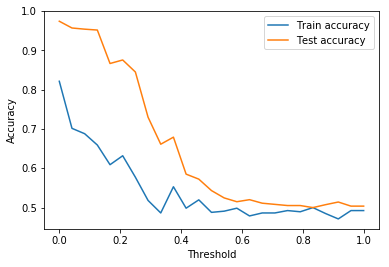

In [58]:
plt.plot(threshold, ta, label='Train accuracy')
plt.plot(threshold, tra, label='Test accuracy')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [61]:
model = RandomForestClassifier(n_estimators=1000, min_samples_split=20, n_jobs = -1)
ta, tra = find_threshold(model, threshold, X, y)

threshold : 0.0
threshold : 0.041666666666666664
threshold : 0.08333333333333333
threshold : 0.125
threshold : 0.16666666666666666
threshold : 0.20833333333333331
threshold : 0.25
threshold : 0.29166666666666663
threshold : 0.3333333333333333
threshold : 0.375
threshold : 0.41666666666666663
threshold : 0.4583333333333333
threshold : 0.5
threshold : 0.5416666666666666
threshold : 0.5833333333333333
threshold : 0.625
threshold : 0.6666666666666666
threshold : 0.7083333333333333
threshold : 0.75
threshold : 0.7916666666666666
threshold : 0.8333333333333333
threshold : 0.875
threshold : 0.9166666666666666
threshold : 0.9583333333333333
threshold : 1.0


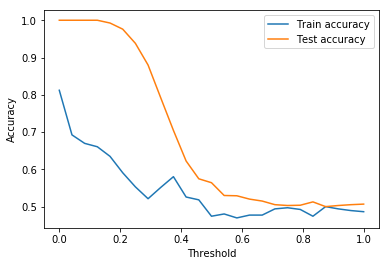

In [62]:
plt.plot(threshold, ta, label='Train accuracy')
plt.plot(threshold, tra, label='Test accuracy')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

We can see that keeping all features perform better.

In [63]:
train_accuracy = []
test_accuracy = []
kf = KFold(n_splits=10, shuffle = False)
for train_index, test_index in kf.split(X):    
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    model = MultinomialNB()
    model.fit(X_train, y_train)
    train_accuracy.append(model.score(X_train, y_train))
    test_accuracy.append(model.score(X_test, y_test))
    #print("Training accuracy : {}".format(model.score(X_train, y_train)))
    #print("Test accuracy : {}".format(model.score(X_test, y_test)))
    #print("Classification report for test set")
    #print(classification_report(y_test, model.predict(X_test)))
print("Train accuracy : {}".format(np.mean(train_accuracy)))
print("Test accuracy : {}".format(np.mean(test_accuracy)))
print(test_accuracy)


Train accuracy : 0.9639444444444443
Test accuracy : 0.8135
[0.805, 0.84, 0.825, 0.775, 0.795, 0.81, 0.82, 0.795, 0.845, 0.825]


In [24]:
y_test[y_test == 'pos']

array(['pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos',
       'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos',
       'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos',
       'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos',
       'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos',
       'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos',
       'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos',
       'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos',
       'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos',
       'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos',
       'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos',
       'pos', 'pos', 'pos'], dtype=object)

In [64]:
train_accuracy = []
test_accuracy = []
kf = KFold(n_splits=10)
for train_index, test_index in kf.split(X):    
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    model = RandomForestClassifier(n_estimators=1000, min_samples_split=20, n_jobs = -1)
    model.fit(X_train, y_train)
    train_accuracy.append(model.score(X_train, y_train))
    test_accuracy.append(model.score(X_test, y_test))
    #print("Training accuracy : {}".format(model.score(X_train, y_train)))
    #print("Test accuracy : {}".format(model.score(X_test, y_test)))
    #print("Classification report for test set")
    #print(classification_report(y_test, model.predict(X_test)))
print("Train accuracy : {}".format(np.mean(train_accuracy)))
print("Test accuracy : {}".format(np.mean(test_accuracy)))
print(test_accuracy)

Train accuracy : 1.0
Test accuracy : 0.8225
[0.81, 0.815, 0.835, 0.79, 0.82, 0.82, 0.84, 0.81, 0.85, 0.835]


In [23]:
model = RandomForestClassifier(n_estimators=1000, min_samples_split=10, n_jobs = -1)
model.fit(X_train, y_train)
print("Training accuracy : {}".format(model.score(X_train, y_train)))
print("Test accuracy : {}".format(model.score(X_test, y_test)))
print("Classification report for test set")
print(classification_report(y_test, model.predict(X_test)))

NameError: name 'X_train' is not defined

In [27]:
tn, fp, fn, tp = confusion_matrix(y_test, model.predict(X_test)).ravel()

In [32]:
print("True Positive : {}, \t False Positive : {} \nTrue Negative : {}, \t False Negative : {}".format(tp, fp, tn, fn))

True Positive : 75, 	 False Positive : 7 
True Negative : 91, 	 False Negative : 27


In [48]:
df = pd.read_csv("Our_Data/text.csv", index_col=0)

In [49]:
df

,text
id,
1,About as exciting as a trip to Hogwarts's most...
2,"More workmanlike than magical, 'Fantastic Beas..."
3,"Despite being light in the story department, T..."
4,With too much happening all at once and not en...
5,Part Two of J.K. Rowling's latest franchise is...
6,It's not only the film's boring lack of origin...
7,It's always fun to decry a formulaic movie - e...
8,Although 'Creed 2' doesn't have the same rousi...
9,Merely adopting a formula is easy - that happe...


In [50]:
texts = df['text'].tolist()

In [65]:
model = RandomForestClassifier(n_estimators=1000, min_samples_split=10, n_jobs = -1)
model.fit(X, y)
X_test = vectorizer.transform(texts)
print("Training accuracy : {}".format(model.score(X, y)))
df.assign(scores = model.predict(X_test))

Training accuracy : 1.0


,text,scores
id,,
1,About as exciting as a trip to Hogwarts's most...,pos
2,"More workmanlike than magical, 'Fantastic Beas...",pos
3,"Despite being light in the story department, T...",pos
4,With too much happening all at once and not en...,neg
5,Part Two of J.K. Rowling's latest franchise is...,pos
6,It's not only the film's boring lack of origin...,pos
7,It's always fun to decry a formulaic movie - e...,pos
8,Although 'Creed 2' doesn't have the same rousi...,pos
9,Merely adopting a formula is easy - that happe...,pos


In [66]:
model = MultinomialNB()
model.fit(X, y)
X_test = vectorizer.transform(texts)
print("Training accuracy : {}".format(model.score(X, y)))
df.assign(scores = model.predict(X_test))

Training accuracy : 0.96


,text,scores
id,,
1,About as exciting as a trip to Hogwarts's most...,neg
2,"More workmanlike than magical, 'Fantastic Beas...",pos
3,"Despite being light in the story department, T...",neg
4,With too much happening all at once and not en...,neg
5,Part Two of J.K. Rowling's latest franchise is...,pos
6,It's not only the film's boring lack of origin...,neg
7,It's always fun to decry a formulaic movie - e...,neg
8,Although 'Creed 2' doesn't have the same rousi...,pos
9,Merely adopting a formula is easy - that happe...,pos


In this case, Naïve-Bayes work a lot better than random forest classifier.

In [71]:
contigency = pd.DataFrame(index=vectorizer.get_feature_names(),data = 0, columns=['pos', 'neg'])

None


In [142]:
from gensim.parsing.preprocessing import preprocess_documents, preprocess_string, strip_tags, strip_punctuation, remove_stopwords, strip_numeric
import swifter

In [165]:
CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, strip_punctuation, strip_numeric, remove_stopwords]
data['preprocess'] = data['text'].swifter.apply(lambda x: preprocess_string(x, CUSTOM_FILTERS))

Pandas Apply: 100%|██████████| 2000/2000 [00:00<00:00, 2833.76it/s]


In [77]:
data['preprocess']

1285    [ive, got, admit, im, huge, jim, carrey, fan, ...
1817    [sydney, lumet, director, work, happens, varie...
1351    [watching, loser, occurred, amy, heckerlings, ...
937     [note, consider, portions, following, text, sp...
1272    [synopsis, sonny, koufax, adam, sandler, rich,...
1506    [kind, movie, makes, appreciate, disneys, live...
657     [national, lampoons, animal, house, set, remai...
35      [oliver, stones, natural, born, killers, movie...
314     [hard, recommend, supernatural, thriller, writ...
22      [gattaca, represents, solid, breakthrough, rec...
250     [frequently, read, reviews, likely, surprised,...
1889    [capsule, friends, stag, party, involved, acci...
1298    [friend, invites, movie, film, evade, explosio...
143     [people, dislike, french, films, lack, closure...
132     [sociologist, attest, childhood, types, parent...
257     [man, island, character, quotes, john, donne, ...
873     [know, million, previously, undiscovered, airp...
265     [saw, 

In [82]:
np.unique(data['preprocess'][0], return_counts=True)

(array(['acting', 'action', 'adaptation', 'alicia', 'alive', 'americans',
        'armageddon', 'arnold', 'awakens', 'bad', 'bandages', 'basically',
        'bastards', 'battle', 'beater', 'beetles', 'begins', 'better',
        'blast', 'bob', 'boris', 'brendan', 'brother', 'brought', 'buddy',
        'buried', 'cares', 'course', 'crawl', 'decent', 'deep', 'director',
        'directorial', 'doesnt', 'effects', 'effort', 'egyptian', 'encino',
        'engulfed', 'entertaining', 'favorite', 'film', 'flesheating',
        'flies', 'focuses', 'folks', 'forgiveness', 'fraser', 'frasers',
        'gets', 'godzilla', 'ground', 'guess', 'guy', 'half', 'hanna',
        'happy', 'havoc', 'horrorloving', 'ihmoetep', 'ihmoeteps',
        'industrial', 'intense', 'invincible', 'isnt', 'j', 'john', 'jolt',
        'karloff', 'kevin', 'king', 'later', 'lead', 'librarian', 'light',
        'like', 'lines', 'little', 'looking', 'magic', 'making', 'man',
        'menace', 'mistress', 'movie', 'mummy', 

In [85]:
data.head()

,text,type,preprocess
1285,ive got to admit it \nim a huge jim carrey ...,neg,"[ive, got, admit, im, huge, jim, carrey, fan, ..."
1817,sydney lumet is the director whose work happen...,neg,"[sydney, lumet, director, work, happens, varie..."
1351,while watching loser it occurred to me that a...,neg,"[watching, loser, occurred, amy, heckerlings, ..."
937,note some may consider portions of the follow...,pos,"[note, consider, portions, following, text, sp..."
1272,synopsis sonny koufax adam sandler is a ric...,neg,"[synopsis, sonny, koufax, adam, sandler, rich,..."


In [7]:
contigency = []
for text in data.iterrows():
    words_list = {}
    for word in vectorizer.get_feature_names():
        if word in text[1]['text']:
            words_list[word] = True
        else:
            words_list[word] = False
    contigency.append(words_list)

In [37]:
pos = pd.DataFrame(contigency[0:1000])
neg = pd.DataFrame(contigency[1000:2000])

In [10]:
pos.head()

,00,000,0009f,000acre,000aweek,000foot,000paltry,007,007esque,00s,...,zuko,zukovsky,zulu,zundel,zurgs,zweibel,zwick,zwicks,zwigoffs,zycie
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [61]:
def getWordContigency(word, pos, neg):
    a = pos[word].value_counts()
    if True not in a:
        a = a.append(pd.Series([0], index=[True]))
    elif False not in a:
        a = a.append(pd.Series([0], index=[False]))
    b = neg[word].value_counts()
    if True not in b:
        b = b.append(pd.Series([0], index=[True]))
    elif False not in b:
        b = b.append(pd.Series([0], index=[False]))
    return [[a[True], b[True]], [a[False], b[False]]]

In [62]:
def getProbaWord(word, pos, neg):
    a = pos[word].value_counts()
    if True not in a:
        a[True] = 0
    elif False not in a:
        a[False] = 0
    b = neg[word].value_counts()
    if True not in b:
        b[True] = 0
    elif False not in b:
        b[False] = 0
    return a[True] + b[True] / 2000

In [91]:
def mutualInfo(matrix):
    proba = [[]]
    I = 0
    proba_word = [(matrix[0][0] + matrix[0][1]) / 2000, 1 - (matrix[0][0] + matrix[0][1]) / 2000]
    for i in range(0, 2):
        for j in range(0, 2):
            p = matrix[i][j] / 2000
            if math.isclose(p, 0, rel_tol = 1e-09):
                continue
            I += p * math.log2(p / (proba_word[i] * 1/2))
    return I

In [92]:
MI = {}
for word in vectorizer.get_feature_names():
    matrix = getWordContigency(word, pos, neg)
    MI[word] = mutualInfo(matrix)

In [93]:
import operator
sorted_x = sorted(MI.items(), key=operator.itemgetter(1))

In [110]:
sorted_x[-11:-1]

[('tic', 0.004178832380025699),
 ('galaxy', 0.00424645841572219),
 ('article', 0.00432844258238717),
 ('mayor', 0.00432844258238717),
 ('rebellious', 0.004427525444383728),
 ('results', 0.004459760462118188),
 ('disgrace', 0.004514673367188056),
 ('corporation', 0.004929088129565819),
 ('goodhearted', 0.005018124385838436),
 ('marys', 0.005018124385838436)]

In [178]:
WORD_DICT = [ w[0] for w in sorted_x[-2001:-1]]

In [179]:
data.head()

,text,type,preprocess,text2
271,in a flashback the teenage girl in the eccent...,pos,"[flashback, tells, school, dance, wants, knows...",flashback tells school dance wants knows rule ...
1393,the ads make hanging up seem like an upbeat ...,neg,"[like, rascally, father, daughters, movie, inc...",like rascally father daughters movie included ...
983,no matter what you suspect this isnt your usu...,pos,"[matter, thriller, crime, revealed, rapidfire,...",matter thriller crime revealed rapidfire want ...
411,warning this review contains some spoilers fo...,pos,"[review, contains, caution, walter, bernstein,...",review contains caution walter bernstein young...
1790,first impressions critically a closetoawful ...,neg,"[moneywise, sometimesfunny, lags, gets, films,...",moneywise sometimesfunny lags gets films thoug...


In [180]:
def filter_words(s):
    words = []
    for w in s:
        if w in WORD_DICT:
            words.append(w)
    return words

In [181]:
CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, strip_punctuation, strip_numeric, remove_stopwords]
data['preprocess'] = data['text'].swifter.apply(lambda x: preprocess_string(x, CUSTOM_FILTERS))

Pandas Apply: 100%|██████████| 2000/2000 [00:00<00:00, 3024.23it/s]


In [182]:
type(data['preprocess'][0])

list

In [183]:
data['preprocess'] = data['preprocess'].swifter.apply(lambda x: filter_words(x))

Pandas Apply: 100%|██████████| 2000/2000 [00:14<00:00, 142.36it/s]


In [184]:
data['text2'] = data['preprocess'].swifter.apply(lambda x : ' '.join(word for word in x))

Pandas Apply: 100%|██████████| 2000/2000 [00:00<00:00, 181003.52it/s]


In [185]:
data['text2']

271     dance household hes hes sister rosemary keller...
1393    walter trophy bernard finally apparently siste...
983                     boss best explain service watched
411     walter aftereffects devastating discord center...
1790        gets type vincent galaxy galaxy joness joness
382     let fans watched warned let best ear walk type...
1941    screen happens officer elisabeth apparent negl...
1485    query outworld shao havoc sorcerer liu outworl...
1877          half finally painfully restored pans sucked
1107    cruz best sickness cruz born cure sickness sea...
964     mantle fresh kay screen best companys showcase...
877     buy finally robert hes hes hes gamely prayer h...
307     skeptical big robert gets tent theyre apparent...
1876    talent theyre theyre sort theyre theyre theyre...
1758                                   half finally awake
1795    finally bruce horribly screen placing stuck st...
387     arrival buy steven robert betrayal gets best b...
1436    walter

In [186]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['text2'])
y = data['type'].as_matrix()

In [187]:
model = MultinomialNB()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
model.fit(X_train, y_train)
print("Training accuracy : {}".format(model.score(X_train, y_train)))
print("Test accuracy : {}".format(model.score(X_test, y_test)))
print("Classification report for test set")
print(classification_report(y_test, model.predict(X_test)))

Training accuracy : 0.8885714285714286
Test accuracy : 0.6216666666666667
Classification report for test set
             precision    recall  f1-score   support

        neg       0.62      0.64      0.63       299
        pos       0.63      0.60      0.61       301

avg / total       0.62      0.62      0.62       600



In [188]:
CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, strip_punctuation, strip_numeric, remove_stopwords]
data['preprocess'] = data['text'].swifter.apply(lambda x: preprocess_string(x, CUSTOM_FILTERS))

Pandas Apply: 100%|██████████| 2000/2000 [00:00<00:00, 3104.54it/s]


In [189]:
from nltk import pos_tag

In [192]:
data['pos'] = data['preprocess'].swifter.apply(lambda x: pos_tag(x))

Pandas Apply: 100%|██████████| 2000/2000 [00:32<00:00, 60.65it/s]


In [194]:
data['pos'] = data['pos'].swifter.apply(lambda x: [w[1] for w in x])

Pandas Apply: 100%|██████████| 2000/2000 [00:00<00:00, 45487.67it/s]


In [206]:
model = MultinomialNB()
X = data['pos'].swifter.apply(lambda x: np.array(x))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
model.fit(X_train, y_train)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



ValueError: Expected 2D array, got 1D array instead:
array=[list(['NNS', 'VBP', 'NN', 'NN', 'VBP', 'NN', 'NN', 'NN', 'NN', 'VBD', 'NN', 'NN', 'JJ', 'NN', 'NNS', 'VBD', 'NN', 'NN', 'VBG', 'NN', 'NN', 'JJ', 'NN', 'NNS', 'JJ', 'NNS', 'VBP', 'VB', 'RB', 'JJ', 'NN', 'JJ', 'NN', 'VBG', 'NNS', 'RB', 'JJ', 'NN', 'NNS', 'VBP', 'JJ', 'NN', 'NN', 'VBZ', 'JJ', 'JJ', 'NN', 'NN', 'VBD', 'JJ', 'NN', 'NN', 'NN', 'VBN', 'JJ', 'NN', 'NN', 'JJ', 'JJ', 'NN', 'NN', 'JJ', 'NN', 'JJ', 'NN', 'NN', 'VBZ', 'NN', 'VBD', 'JJ', 'NN', 'VBN', 'NN', 'NN', 'RB', 'NN', 'NNS', 'VBD', 'NNS', 'VBG', 'NN', 'JJ', 'NN', 'NN', 'NN', 'JJS', 'NN', 'NN', 'NN', 'NN', 'NN', 'JJ', 'NN', 'NN', 'NN', 'NN', 'NN', 'VBG', 'NNS', 'JJ', 'JJ', 'NN', 'NN', 'JJ', 'NN', 'RB', 'JJ', 'NN', 'NN', 'NN', 'NNS', 'VBD', 'JJ', 'NN', 'NN', 'VBZ', 'VBG', 'JJ', 'NNS', 'VBP', 'RB', 'VBN', 'NN', 'NNS', 'VBD', 'NNS', 'VB', 'RB', 'JJ', 'VBG', 'JJ', 'NN', 'VBN', 'NN', 'NN', 'NN', 'VBP', 'VBN', 'NN', 'VBG', 'JJ', 'NN', 'NN', 'NN', 'VBP', 'NN', 'NN', 'NN', 'NN', 'NN', 'CD', 'NN'])
 list(['NN', 'NN', 'JJ', 'NN', 'JJ', 'JJ', 'NN', 'VBD', 'RB', 'JJ', 'RB', 'VBP', 'NN', 'NNS', 'VBP', 'JJ', 'JJ', 'NN', 'JJ', 'NN', 'NN', 'VBP', 'JJ', 'IN', 'JJ', 'NN', 'NN', 'NN', 'VBZ', 'JJ', 'NN', 'VBP', 'IN', 'NN', 'NN', 'VBZ', 'JJ', 'NN', 'NN', 'NNS', 'VBD', 'NN', 'NN', 'NNS', 'VBP', 'NNS', 'VBP', 'JJ', 'NN', 'RB', 'VBZ', 'NN', 'NN', 'VBZ', 'VBP', 'JJ', 'JJ', 'VBZ', 'JJ', 'NN', 'VBP', 'NN', 'NN', 'VBZ', 'RB', 'NNS', 'VBP', 'NN', 'JJ', 'JJ', 'NNS', 'VBP', 'VB', 'NNS', 'NN', 'NNS', 'IN', 'VBN', 'CD', 'NNS', 'JJ', 'NN', 'NN', 'VBZ', 'VBG', 'NN', 'VBG', 'NN', 'NN', 'VBZ', 'JJ', 'NN', 'VBZ', 'JJ', 'JJ', 'NN', 'NN', 'NN', 'VBN', 'NN', 'VBG', 'NNS', 'VBN', 'NNS', 'JJ', 'NN', 'VBP', 'JJ', 'JJ', 'NN', 'NN', 'VBN', 'NN', 'VBD', 'RB', 'JJ', 'JJ', 'NNS', 'NN', 'RB', 'VB', 'VB', 'JJ', 'JJ', 'JJ', 'NN', 'NNS', 'VBP', 'VBG', 'NN', 'NN', 'JJ', 'NN', 'IN', 'VBZ', 'NNS', 'NN', 'VBD', 'JJ', 'NN', 'NN', 'NN', 'NN', 'VBD', 'RB', 'JJ', 'NN', 'NN', 'VBG', 'NN', 'NN', 'VBP', 'NN', 'NN', 'NNS', 'VBZ', 'VBP', 'NN', 'VBG', 'JJ', 'NN', 'VBP', 'NN', 'VBN', 'VB', 'JJ', 'JJ', 'NN', 'NN', 'NN', 'NNS', 'NNS', 'VBD', 'JJ', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'VBZ', 'RB', 'JJ', 'VBG', 'JJ', 'VBZ', 'NNS', 'RB', 'NN', 'JJ', 'JJ', 'NNS', 'VBP', 'NN', 'NN', 'IN', 'JJ', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'JJ', 'NN', 'JJ', 'NNS', 'VBP', 'NN', 'NNS', 'VBD', 'NNS', 'VB', 'RB', 'JJ', 'NN', 'NNS', 'VBP', 'JJ', 'JJ', 'NN', 'JJ', 'NNS', 'VBP', 'NNS', 'NNS', 'VBG', 'JJ', 'NN', 'VBZ', 'JJ', 'NN', 'NN', 'JJ', 'CC', 'NN', 'NN', 'VBD', 'JJ', 'NN', 'NN', 'NN', 'VBD', 'RB', 'RB', 'JJ', 'JJ', 'NN', 'NNS', 'VBP', 'JJR', 'VBN', 'CD', 'NNS', 'JJ', 'NNS'])
 list(['NN', 'JJ', 'VBD', 'JJ', 'NN', 'NN', 'JJ', 'NN', 'VBN', 'JJ', 'JJ', 'VBZ', 'NNS', 'NNS', 'VBP', 'JJ', 'JJ', 'NN', 'VBN', 'JJ', 'VBZ', 'NNS', 'NN', 'JJ', 'VBZ', 'JJ', 'JJ', 'NN', 'VBZ', 'NNS', 'VBP', 'JJ', 'JJ', 'NN', 'VBZ', 'JJ', 'JJ', 'NN', 'NN', 'JJ', 'VBG', 'VBG', 'VBG', 'NN', 'RB', 'JJ', 'JJR', 'NN', 'JJ', 'NN', 'JJ', 'VBD', 'JJ', 'JJ', 'NN', 'VBN', 'NNP', 'NN', 'NN', 'NN', 'JJ', 'NN', 'VBG', 'JJ', 'NN', 'VBD', 'JJS', 'JJ', 'NN', 'VBD', 'JJ', 'VBZ', 'NN', 'NN', 'NN', 'NNS', 'RB', 'VBD', 'RB', 'VBN', 'NNS', 'VBP', 'NN', 'VBZ', 'JJ', 'NN', 'NNS', 'NN', 'NN', 'JJ', 'NN', 'NN', 'NN', 'NN', 'VBN', 'IN', 'JJ', 'NN', 'NN', 'RB', 'JJ', 'NN', 'VBP', 'NN', 'NN', 'VBG', 'JJ', 'NN', 'NN', 'NNS', 'VBP', 'JJ', 'NN', 'VBD', 'VBG', 'JJ', 'NNS', 'NNS', 'NNS', 'VBP', 'NNS', 'NNS', 'NNS', 'VBP', 'VB', 'RB', 'JJ', 'JJ', 'NN', 'NN', 'NNS', 'VBP', 'NN', 'NN', 'JJ', 'NN', 'NN', 'NNS', 'JJ', 'VBZ', 'NN', 'NN', 'RB', 'NN', 'RBR', 'JJ', 'JJ', 'NNS', 'VBG', 'JJ', 'NN', 'RB', 'JJ', 'NN', 'VBZ', 'JJ', 'NN', 'NN', 'NN', 'VBD', 'JJ', 'NN', 'NN', 'NN', 'VBN', 'JJ', 'NN', 'VBG', 'NNS', 'VBG', 'JJ', 'NN', 'JJ', 'NN', 'JJ', 'JJ', 'NN', 'VBD', 'VBG', 'JJ', 'NN', 'NN', 'VBG', 'JJ', 'JJ', 'NN', 'NN', 'NNS', 'VBD', 'JJ', 'NN', 'RB', 'NN', 'NNS', 'RB', 'NNS', 'JJ', 'NNS', 'VBG', 'NN', 'NN', 'VB', 'NN', 'VBG', 'NNS', 'RB', 'VBZ', 'NN', 'NNS', 'NN', 'JJ', 'NN', 'NN', 'NNS', 'VBP', 'NN', 'NN', 'NN', 'JJ', 'NN', 'VB', 'JJR', 'NN', 'NN', 'VBD', 'JJS', 'NN', 'VBD', 'CD', 'NNS', 'JJ', 'JJS', 'NN', 'NN', 'NNS', 'JJ', 'NNS', 'NN', 'VBG', 'NN', 'NNS', 'RB', 'VBP', 'RB', 'JJ', 'NN', 'IN', 'RB', 'VBG', 'NN', 'NN', 'NN', 'NN', 'NN', 'VBG', 'JJ', 'NN', 'VBP', 'JJR', 'JJ', 'NN', 'NN', 'JJ'])
 ...
 list(['NNS', 'NN', 'JJ', 'NN', 'NN', 'NN', 'VB', 'RB', 'VBN', 'NN', 'VBZ', 'VBG', 'JJ', 'VBG', 'JJ', 'NN', 'NN', 'NN', 'NN', 'VBZ', 'NN', 'NN', 'VBG', 'JJ', 'NN', 'VBD', 'CD', 'JJ', 'NN', 'NN', 'NNS', 'VBP', 'RB', 'JJ', 'VBZ', 'JJ', 'NN', 'VBZ', 'JJ', 'JJR', 'NN', 'VBD', 'NNS', 'JJ', 'RB', 'RB', 'RB', 'JJ', 'VBD', 'JJ', 'NN', 'VBZ', 'RB', 'JJ', 'NN', 'VBG', 'VBP', 'JJ', 'RB', 'NN', 'NN', 'VBZ', 'NN', 'JJ', 'NNS', 'RB', 'JJ', 'NN', 'JJ', 'NN', 'NN', 'JJ', 'NN', 'VBN', 'NNS', 'JJ', 'NNS', 'RB', 'JJ', 'NN', 'NN', 'VBZ', 'VBG', 'NN', 'JJ', 'VBP', 'JJ', 'NN', 'NN', 'RB', 'NNS', 'VBP', 'NN', 'NN', 'NN', 'NN', 'DT', 'JJ', 'NN', 'NN', 'VBZ', 'NN', 'JJ', 'JJ', 'RB', 'JJ', 'NN', 'NN', 'VBZ', 'NN', 'NN', 'NN', 'NN', 'VBG', 'NN', 'JJ', 'NNS', 'VBP', 'PRP$', 'NN', 'JJ', 'NNS', 'VBP', 'JJ', 'NN', 'VBG', 'RB', 'VBG', 'VBG', 'JJ', 'RB', 'VBN', 'NN', 'NN', 'NN', 'VBG', 'JJ', 'NN', 'NNS', 'VBG', 'VBG', 'JJ', 'NN', 'NN', 'NN', 'JJS', 'NN', 'NN', 'NN', 'VBP', 'JJ', 'NN', 'NN', 'NN', 'VBP', 'NN', 'NN', 'NN', 'NNS', 'VBP', 'NN', 'VBG', 'NNS', 'NN', 'NN', 'VBG', 'NNS', 'JJ', 'NNS', 'VBP', 'NNS', 'VBG', 'NNS', 'VBG', 'NNS', 'NN', 'VBD', 'NNS', 'JJ', 'NN', 'VBD', 'JJ', 'JJ', 'NN', 'NN', 'NN', 'VBZ', 'RB', 'VBZ', 'VBN', 'NN', 'JJ', 'VBP', 'JJ', 'NN', 'NNS', 'VBG', 'NN', 'NNS', 'NN', 'NN', 'NNS', 'NNS', 'VBP', 'NN', 'NN', 'VBG', 'JJ', 'NN', 'NN', 'VBZ', 'JJ', 'NNS', 'NN', 'VBG', 'JJ', 'NN', 'NNS', 'JJ', 'JJ', 'NN', 'NN', 'VBD', 'NN', 'VBN', 'NN', 'NN', 'JJ', 'NNS', 'VBG', 'JJ', 'JJ', 'NN', 'NN', 'NNS', 'VBP', 'NN', 'NN', 'JJ', 'NN', 'NN', 'NN', 'JJ', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'VBZ', 'RB', 'JJ', 'JJ', 'NN', 'NNS', 'VBZ', 'JJ', 'NN', 'JJ', 'NN', 'NN', 'NN', 'RB', 'VB', 'JJ', 'NN', 'NNS', 'VBP', 'RB', 'VBG', 'NN', 'NN', 'NN', 'VBP', 'NN', 'NN', 'VBD', 'NN', 'NN', 'JJ', 'JJ', 'NNS', 'VBP', 'NNS', 'VBP', 'RB', 'JJ', 'NNS', 'JJ', 'JJ', 'NN', 'NN', 'NN', 'NN', 'RB', 'VBD', 'NN', 'NN', 'VBZ', 'NN', 'JJ', 'NN', 'NN', 'VBD', 'NN', 'JJ', 'NNS', 'VBP', 'VBG', 'RB', 'NN', 'NN', 'VBP', 'NN', 'VBG', 'JJ', 'NN', 'NNS', 'JJ', 'VBD', 'JJS', 'NN', 'JJ', 'NNS', 'VBN', 'NN', 'VBD', 'NN', 'NN', 'RB', 'VBD', 'NN', 'NN', 'RB', 'NN', 'VBZ', 'VBZ', 'JJ', 'JJ', 'NN', 'NN', 'NN', 'NNS', 'VBG', 'NN', 'NN', 'VBZ', 'RB', 'RB', 'JJ', 'JJ', 'NN', 'RB', 'NN', 'JJ', 'NN', 'NN', 'VBD', 'JJ', 'NN', 'NNS', 'RB', 'JJ', 'NN', 'NN', 'NN', 'NN', 'NN', 'JJ', 'NN', 'NN', 'NN', 'IN', 'JJ', 'NN', 'NN', 'VBD', 'JJ', 'NN', 'NN', 'JJ', 'NN', 'VBG', 'JJ', 'NNS', 'NN', 'NN', 'JJ', 'NN', 'VBP', 'VBN', 'NNS', 'JJ', 'NN', 'NN', 'NN', 'VBG', 'JJ', 'NN', 'NN', 'RB', 'NN', 'NN', 'JJ', 'NN', 'JJ', 'NN', 'NNS', 'VBP', 'JJ', 'NN', 'NN', 'VB', 'NN', 'FW', 'NN', 'NNS', 'VBP', 'NNS', 'RB', 'VBP', 'NNS', 'JJ', 'JJ', 'NNS', 'NN', 'NN', 'JJ', 'JJ', 'NN', 'VBN', 'VBZ', 'NNS', 'RB', 'VBP', 'RB', 'NN', 'NN', 'NNS', 'VBG', 'RB', 'NNS', 'VBG', 'NNS', 'JJ', 'NNS', 'VBG', 'NN', 'JJ', 'NN', 'IN', 'VBG', 'RB', 'JJ', 'NN', 'VBZ', 'NNS', 'JJ', 'NN', 'NN', 'VBZ', 'JJ', 'NN', 'NN', 'JJ', 'NN', 'VBN', 'NN', 'NN', 'NN', 'NN', 'NNS', 'VBP', 'NNS', 'JJ', 'JJ', 'NN', 'NN', 'NN', 'NN', 'VBD', 'JJ', 'NN', 'NN', 'VBG', 'NNS', 'VBP', 'IN', 'NN', 'NN', 'VBZ', 'NN', 'NN', 'VBZ', 'VBG', 'NN', 'VBZ', 'JJ', 'NN', 'VBZ', 'JJ', 'NN', 'JJ', 'NNS', 'VBP', 'RB', 'VBP', 'NN', 'IN', 'NN', 'NN', 'NN', 'JJ', 'JJ', 'NN', 'NNS', 'IN', 'NN', 'VBG', 'NN', 'RB', 'VBG', 'JJ', 'NN', 'NN', 'NNP', 'NN', 'NN', 'JJ', 'NN', 'VBD', 'RB', 'JJ', 'NN', 'NN', 'NN', 'NN', 'RB', 'JJ', 'NN', 'NN', 'NNS', 'RB', 'VBG', 'NN', 'VBN', 'NNS', 'RBR', 'RB', 'VBG', 'PRP', 'NN', 'IN', 'NN', 'VBP', 'NNS', 'JJ', 'JJ', 'NN', 'NN', 'NN', 'VB', 'JJ', 'JJ', 'NN', 'VBZ', 'JJ', 'NN', 'VBG', 'VBN', 'JJ', 'NN', 'NN', 'VBZ', 'NN', 'NN', 'VBG', 'NN', 'NN', 'VBD', 'JJ', 'NN', 'NN', 'NN', 'VBG', 'JJ', 'JJ', 'JJ', 'JJ', 'NN', 'RB', 'NN', 'NN', 'VBG', 'JJ', 'JJ', 'NN', 'NN', 'VBG', 'VBD', 'NN', 'NN', 'NN', 'NN', 'JJ', 'NN', 'NN', 'NN', 'RB', 'JJ', 'NN', 'NNS', 'VBP', 'VBP', 'NN', 'NN', 'RB', 'VBD', 'RB', 'JJ', 'NN', 'VBN', 'JJ', 'NN', 'NNS', 'NN', 'JJ', 'NNS', 'VBP', 'NN', 'NNS', 'VBP', 'RB', 'JJ', 'JJ', 'NN', 'NN', 'JJ', 'NN', 'NN', 'RB', 'NNS', 'VBP', 'NN', 'NNS'])
 list(['NN', 'JJ', 'JJ', 'VBN', 'JJ', 'VBG', 'NN', 'NN', 'NN', 'NNS', 'VBP', 'JJ', 'NN', 'JJ', 'JJ', 'NN', 'NN', 'VBZ', 'NN', 'NNS', 'NNS', 'VBD', 'RB', 'RB', 'VBG', 'NN', 'NN', 'NN', 'NN', 'NNS', 'VBP', 'NNS', 'VBG', 'NNS', 'JJ', 'NNS', 'VBG', 'IN', 'JJ', 'NN', 'VBZ', 'NN', 'JJ', 'NN', 'NN', 'NNS', 'NN', 'NN', 'VBZ', 'VBP', 'NNS', 'RBR', 'JJ', 'NN', 'NN', 'RB', 'VBZ', 'NNS', 'NN', 'VBP', 'JJ', 'NN', 'NN', 'NN', 'JJ', 'VBP', 'NNS', 'VB', 'VBG', 'NNS', 'NN', 'NN', 'JJ', 'JJ', 'NN', 'NNS', 'JJ', 'JJ', 'NN', 'VBG', 'NNS', 'JJ', 'JJ', 'NNS', 'VBP', 'JJ', 'JJ', 'JJ', 'NN', 'VBG', 'JJ', 'JJS', 'NN', 'RB', 'VBZ', 'JJ', 'NN', 'NN', 'VBZ', 'NNS', 'RB', 'VBG', 'VBZ', 'NNS', 'RBR', 'JJ', 'VBG', 'NN', 'NN', 'JJ', 'RB', 'JJ', 'NN', 'NN', 'RB', 'VBZ', 'RB', 'JJ', 'NN', 'VBN', 'NN', 'NN', 'NN', 'NN', 'VBP', 'JJ', 'NN', 'VB', 'JJ', 'VBP', 'NN', 'NNS', 'NN', 'NN', 'VBP', 'NN', 'NN', 'JJ', 'NN', 'NN', 'JJ', 'JJ', 'NNS', 'VBZ', 'JJ', 'JJ', 'NN', 'NNS', 'JJ', 'JJ', 'NN', 'NN', 'VBZ', 'JJ', 'NN', 'VBD', 'VBG', 'JJ', 'NN', 'JJ', 'NN', 'NN', 'NN', 'NN', 'RB', 'JJ', 'NN', 'NN', 'VBZ', 'NN', 'RB', 'VBZ', 'NN', 'JJ', 'JJ', 'JJ', 'NN', 'VBD', 'JJ', 'VBG', 'NN', 'NN', 'VBD', 'NN', 'NN', 'VBG', 'JJS', 'NNS', 'NN', 'NN'])
 list(['NN', 'NN', 'JJ', 'JJ', 'NN', 'JJ', 'NN', 'NNS', 'VBP', 'NNS', 'JJ', 'NN', 'NN', 'NNS', 'VBP', 'VBZ', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'VBG', 'NN', 'NNS', 'VBP', 'RB', 'VBG', 'VBN', 'NN', 'NNS', 'NNS', 'VBP', 'NN', 'NN', 'JJ', 'NN', 'NNS', 'VBP', 'NNS', 'VBP', 'JJ', 'NN', 'VBD', 'NN', 'NNS', 'NN', 'VBZ', 'NN', 'NN', 'NN', 'NN', 'NN', 'NNS', 'VBP', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'RB', 'JJ', 'VBP', 'RB', 'JJ', 'NN', 'NN', 'NN', 'NNS', 'VBD', 'RBR', 'VBP', 'NN', 'NNS', 'VBP', 'NN', 'NN', 'NN', 'NN', 'NN', 'VBZ', 'JJ', 'NN', 'VBP', 'JJ', 'NN', 'NN', 'NN', 'VBD', 'NNS', 'JJ', 'NN', 'NN', 'VBP', 'JJ', 'VBG', 'JJ', 'NNS', 'VBP', 'NN', 'NN', 'NN', 'NN', 'NNS', 'VBP', 'NN', 'NNS', 'JJ', 'NNS', 'VBP', 'RB', 'JJ', 'NN', 'NN', 'NN', 'NN', 'JJ', 'NN', 'NN', 'JJ', 'NN', 'NN', 'NN', 'VBD', 'NN', 'NN', 'NN', 'NNS', 'JJ', 'JJ', 'NN', 'NNS', 'VBP', 'NN', 'NN', 'VBD', 'NN', 'NN', 'NN', 'VBZ', 'JJR', 'NN', 'RB', 'VBG', 'JJ', 'NN', 'NN', 'VBD', 'VBN', 'NNS', 'RBR', 'NN', 'VBN', 'JJ', 'JJ', 'NN', 'NN', 'NN', 'NN', 'NN', 'VBZ', 'JJ', 'NN', 'JJ', 'NN', 'NN', 'VBD', 'VBZ', 'NN', 'NNS', 'VBP', 'JJ', 'VBG', 'NN', 'VBG', 'NNS', 'NNS', 'VBP', 'VBG', 'JJ', 'JJ', 'NN', 'NNS', 'VBD', 'NN', 'VBN', 'NN', 'VBZ', 'VB', 'NN', 'NN', 'NNS', 'NN', 'JJ', 'JJ', 'NN', 'NN', 'NNS', 'VBP', 'NN', 'NNS', 'VBP', 'JJ', 'JJR', 'NN', 'VBN', 'JJ', 'NN', 'NN', 'VBD', 'NN', 'RB', 'VBZ', 'JJ', 'VBG', 'NNS', 'JJ', 'NNS', 'RBR', 'NNS', 'JJ', 'NN', 'NN', 'NNS', 'JJ', 'NNS'])].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.